# Instalaçoes e bibliotecas necessárias

In [1]:
!pip install unidecode openpyxl imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.8 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import re
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from imblearn.over_sampling import SMOTE

# Carregando dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideojuegos.xlsx")
df = df[['TEXTO', 'Polaridad']].dropna()
#alterar dataset:
#df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideogames_Extension2024.xlsx")

# Função de pré-processamento

In [6]:
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')
tokenizer = TweetTokenizer()


In [7]:
def preprocess(text):
    text = str(text).lower()
    text = unidecode(text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\b(j[aeiou]{1,})+\b', 'jaja', text)
    text = re.sub(r'\bx[o0]+\b', 'pero', text)
    text = re.sub(r'\bxfa\b', 'por favor', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\b(streamlabs|nightbot)\b', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Aplica o pré-processamento

In [8]:
df['clean_text'] = df['TEXTO'].apply(preprocess)

# Vetorização com TF-IDF e preparação de dados


In [9]:
y = df['Polaridad']

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicando SMOTE

In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

analisando distribuição

In [13]:
from collections import Counter
print("Antes do SMOTE:", Counter(y_train))
print("Depois do SMOTE:", Counter(y_train_resampled))

Antes do SMOTE: Counter({'Negativo': 715, 'Positivo': 674, 'Indeterminado': 161})
Depois do SMOTE: Counter({'Negativo': 715, 'Positivo': 715, 'Indeterminado': 715})


#**Definindo modelos**

# Modelo treinado sem SMOTE

In [14]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    random_state=42
)
rf_model.fit(X_train, y_train)

#PARAMETROS ARTIGO: n_estimators=500, max_features='sqrt'
#MEUS PARAMETROS: n_estimators: 500, max_features: 'log2

RandomForestClassifier(n_estimators=500, random_state=42)

In [15]:
svm_model = SVC(C = 150, kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
#PARAMETROS ARTIGO: C=150, kernel='rbf'
#MEUS PARAMETROS: C=1, kernel='rbf'

SVC(C=150, random_state=42)

# Modelo treinado com SMOTE

In [16]:
rfSmote_model = RandomForestClassifier(
    n_estimators=500, max_features='sqrt', random_state=42
)
rfSmote_model.fit(X_train_resampled, y_train_resampled)

#PARAMETROS ARTIGO: n_estimators=500, max_features='sqrt'
#MEUS PARAMETROS: n_estimators: 500, max_features: 'log2

RandomForestClassifier(n_estimators=500, random_state=42)

In [17]:
svmSmote_model = SVC(C=150, kernel='rbf', random_state=42)
svmSmote_model.fit(X_train_resampled, y_train_resampled)

#PARAMETROS ARTIGO: C=150, kernel='rbf'
#MEUS PARAMETROS: C=1, kernel='rbf'

SVC(C=150, random_state=42)

# Realizando predições

In [18]:
rf_pred = rf_model.predict(X_test)

In [19]:
svm_pred = svm_model.predict(X_test)

In [20]:
rfSmote_pred = rfSmote_model.predict(X_test)

In [21]:
svmSmote_pred = svmSmote_model.predict(X_test)

# Resultados

**relatórios de classificação comparativo RANDOM FOREST**

In [22]:
print("\nCLASSIFICAÇÃO RANDOM FOREST SEM SMOTE")
print(classification_report(y_test, rf_pred))

print("\nCLASSIFICAÇÃO RANDOM FOREST COM SMOTE")
print(classification_report(y_test, rfSmote_pred))


CLASSIFICAÇÃO RANDOM FOREST SEM SMOTE
               precision    recall  f1-score   support

Indeterminado       0.67      0.16      0.26        86
     Negativo       0.58      0.81      0.68       285
     Positivo       0.72      0.60      0.66       294

     accuracy                           0.63       665
    macro avg       0.66      0.53      0.53       665
 weighted avg       0.65      0.63      0.61       665


CLASSIFICAÇÃO RANDOM FOREST COM SMOTE
               precision    recall  f1-score   support

Indeterminado       0.33      0.24      0.28        86
     Negativo       0.59      0.74      0.65       285
     Positivo       0.71      0.59      0.65       294

     accuracy                           0.61       665
    macro avg       0.54      0.52      0.53       665
 weighted avg       0.61      0.61      0.60       665



**relatórios de classificação comparativo SVM**

In [23]:
print("\nCLASSIFICAÇÃO SVM SEM SMOTE")
print(classification_report(y_test, svm_pred))

print("\nCLASSIFICAÇÃO SVM COM SMOTE")
print(classification_report(y_test, svmSmote_pred))


CLASSIFICAÇÃO SVM SEM SMOTE
               precision    recall  f1-score   support

Indeterminado       0.68      0.15      0.25        86
     Negativo       0.61      0.82      0.70       285
     Positivo       0.74      0.65      0.69       294

     accuracy                           0.66       665
    macro avg       0.68      0.54      0.55       665
 weighted avg       0.67      0.66      0.64       665


CLASSIFICAÇÃO SVM COM SMOTE
               precision    recall  f1-score   support

Indeterminado       0.38      0.17      0.24        86
     Negativo       0.56      0.69      0.62       285
     Positivo       0.69      0.63      0.66       294

     accuracy                           0.60       665
    macro avg       0.54      0.50      0.51       665
 weighted avg       0.59      0.60      0.59       665



***F1-score Random forest***

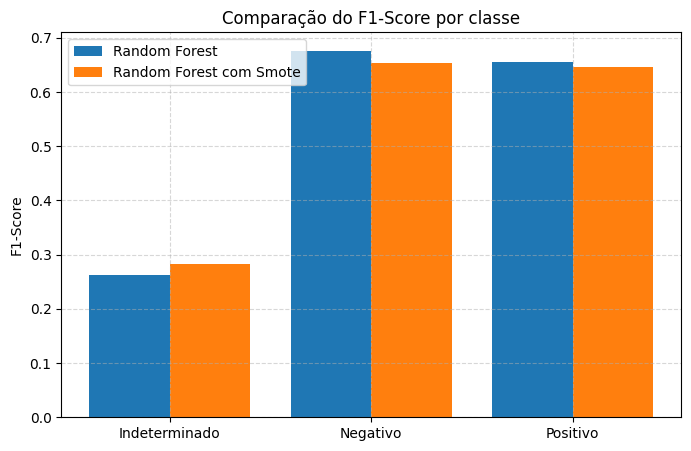

In [24]:
from sklearn.metrics import f1_score

f1_rf = f1_score(y_test, rf_pred, average=None)
f1_rfSmote = f1_score(y_test, rfSmote_pred, average=None)
classes = ['Indeterminado', 'Negativo', 'Positivo']

x = range(len(classes))
plt.figure(figsize=(8, 5))
plt.bar(x, f1_rf, width=0.4, label='Random Forest', align='center')
plt.bar([i + 0.4 for i in x], f1_rfSmote, width=0.4, label='Random Forest com Smote', align='center')
plt.xticks([i + 0.2 for i in x], classes)
plt.ylabel('F1-Score')
plt.title('Comparação do F1-Score por classe')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

***F1-score SVM***

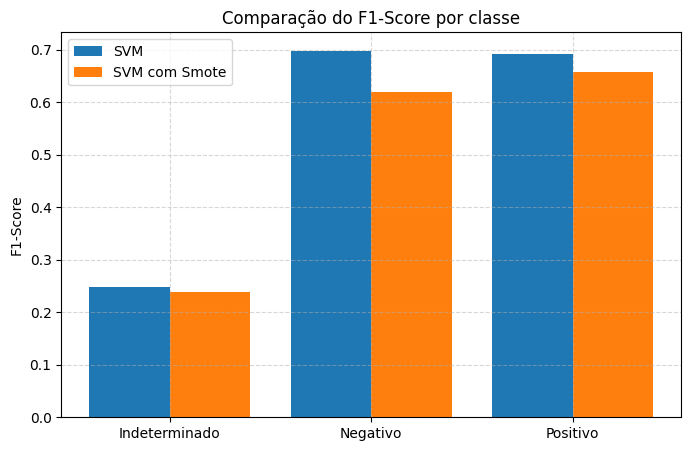

In [25]:
from sklearn.metrics import f1_score

f1_svm = f1_score(y_test, svm_pred, average=None)
f1_svmSmote = f1_score(y_test, svmSmote_pred, average=None)
classes = ['Indeterminado', 'Negativo', 'Positivo']

x = range(len(classes))
plt.figure(figsize=(8, 5))
plt.bar(x, f1_svm, width=0.4, label='SVM', align='center')
plt.bar([i + 0.4 for i in x], f1_svmSmote, width=0.4, label='SVM com Smote', align='center')
plt.xticks([i + 0.2 for i in x], classes)
plt.ylabel('F1-Score')
plt.title('Comparação do F1-Score por classe')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Matrizes de confusão random forest**

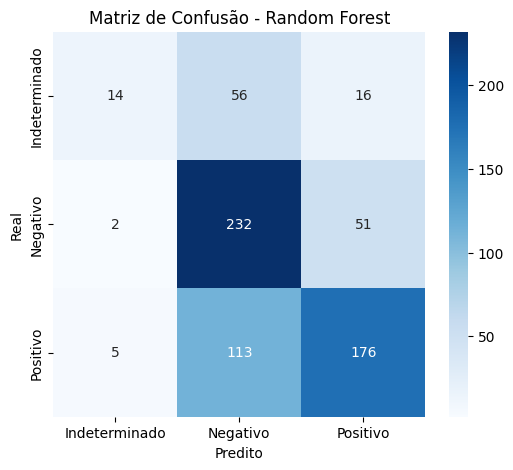

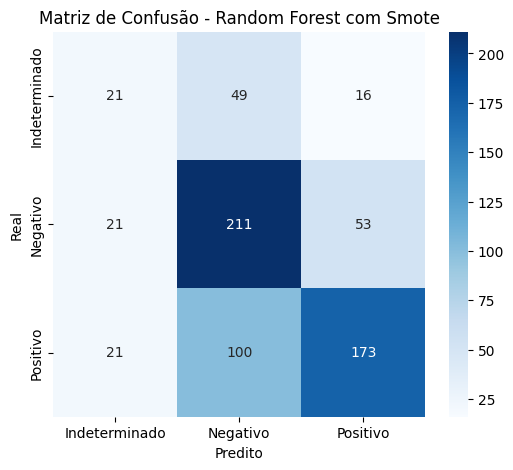

In [26]:
# Gerando matriz
cm_rf = confusion_matrix(y_test, rf_pred, labels=classes)
cm_rfSmote = confusion_matrix(y_test, rfSmote_pred, labels=classes)

# Plot matriz de confusão Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plot matriz de confusão Random Forest com Smote
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rfSmote, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - Random Forest com Smote')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

**Matrizes de confusão SVM**

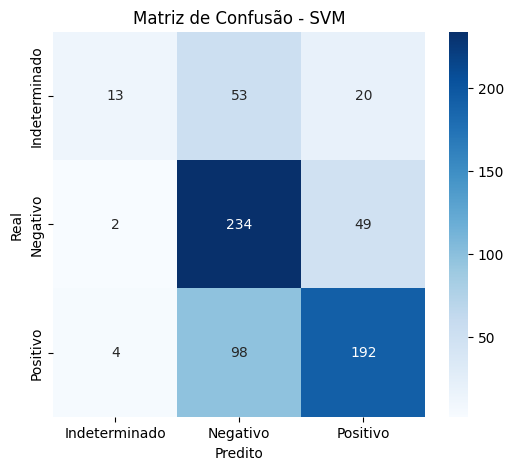

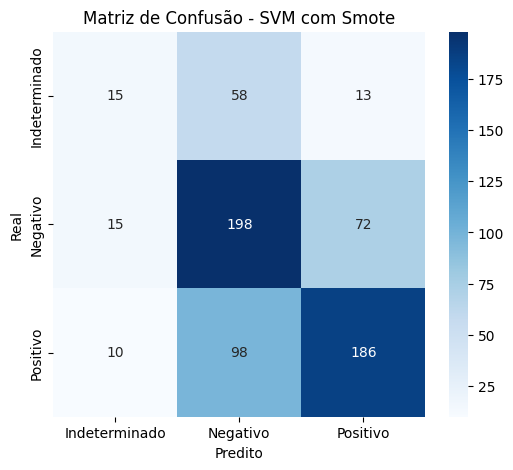

In [27]:
# Gerando matriz
cm_svm = confusion_matrix(y_test, svm_pred, labels=classes)
cm_svmSmote = confusion_matrix(y_test, svmSmote_pred, labels=classes)

# Plot matriz de confusão SVM
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plot matriz de confusão SVM com Smote
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svmSmote, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - SVM com Smote')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()